In [1]:
%matplotlib inline

import os
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [2]:
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
print(os.listdir('data'))

data\archive.zip
data\data0.pickle
data\data1.pickle
data\data2.pickle
data\data3.pickle
data\data4.pickle
data\data5.pickle
data\data6.pickle
data\data7.pickle
data\data8.pickle
data\datasets_preparing.py
data\labels.pickle
data\label_names.csv
data\mean_image_gray.pickle
data\mean_image_rgb.pickle
data\std_gray.pickle
data\std_rgb.pickle
data\test.pickle
data\train.pickle
data\valid.pickle
['archive.zip', 'data0.pickle', 'data1.pickle', 'data2.pickle', 'data3.pickle', 'data4.pickle', 'data5.pickle', 'data6.pickle', 'data7.pickle', 'data8.pickle', 'datasets_preparing.py', 'labels.pickle', 'label_names.csv', 'mean_image_gray.pickle', 'mean_image_rgb.pickle', 'std_gray.pickle', 'std_rgb.pickle', 'test.pickle', 'train.pickle', 'valid.pickle']


In [3]:
with open('data/data2.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')
    
data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)

data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

for i, j in data.items():
    if i == 'labels':
        print(i+':', len(j))
    else:
        print(i+':', j.shape)

y_test: (12630,)
y_validation: (4410, 43)
x_validation: (4410, 32, 32, 3)
x_train: (86989, 32, 32, 3)
y_train: (86989, 43)
labels: 43
x_test: (12630, 32, 32, 3)


(81, 32, 32, 3)


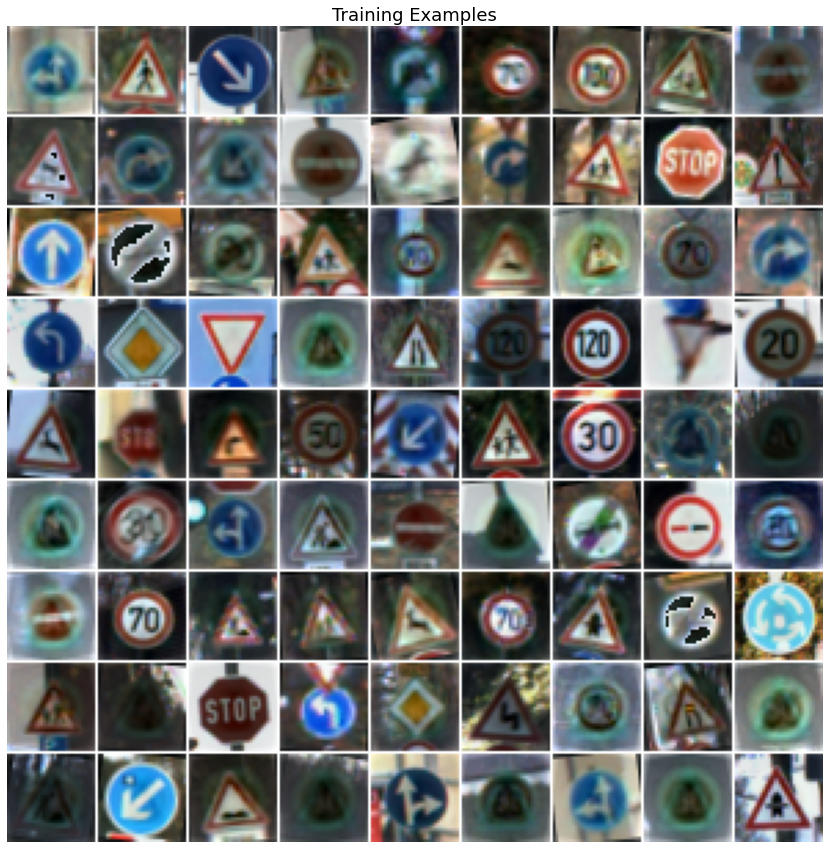

In [4]:
def display_images(x):
    N, H, W, C = x.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H

    for i in range(grid_size):
        x0, x1 = 0, W
        for j in range(grid_size):
            if next_idx < N:
                img = x[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1
    return grid

examples = data['x_train'][:81, :, :, :]
print(examples.shape)


fig = plt.figure()
grid = display_images(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Training Examples', fontsize=18)

plt.show()
fig.savefig('training_examples.png')
plt.close()


In [5]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu',input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
epochs = 10
callback = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))

h = model.fit(data['x_train'], data['y_train'], batch_size=5, epochs=epochs, validation_data=(data['x_validation'], data['y_validation']), callbacks=[callback], verbose=1)

Epoch 1/10
17398/17398 [==============================] - 142s 8ms/step - loss: 0.4859 - accuracy: 0.8718 - val_loss: 0.7732 - val_accuracy: 0.8376 - lr: 5.9874e-04
Epoch 2/10
17398/17398 [==============================] - 141s 8ms/step - loss: 0.1125 - accuracy: 0.9696 - val_loss: 0.7106 - val_accuracy: 0.8603 - lr: 5.6880e-04
Epoch 3/10
17398/17398 [==============================] - 139s 8ms/step - loss: 0.0728 - accuracy: 0.9811 - val_loss: 0.9480 - val_accuracy: 0.8580 - lr: 5.4036e-04
Epoch 4/10
17398/17398 [==============================] - 138s 8ms/step - loss: 0.0485 - accuracy: 0.9870 - val_loss: 0.8870 - val_accuracy: 0.8805 - lr: 5.1334e-04
Epoch 5/10
17398/17398 [==============================] - 139s 8ms/step - loss: 0.0406 - accuracy: 0.9891 - val_loss: 0.9374 - val_accuracy: 0.8769 - lr: 4.8767e-04
Epoch 6/10
17398/17398 [==============================] - 134s 8ms/step - loss: 0.0298 - accuracy: 0.9918 - val_loss: 1.0223 - val_accuracy: 0.8778 - lr: 4.6329e-04
Epoch 7/10

In [7]:
print('Epochs={0:d}, training accuracy={1:.5f}, validation accuracy={2:.5f}'.\
      format(epochs, max(h.history['accuracy']), max(h.history['val_accuracy'])))

Epochs=10, training accuracy=0.99614, validation accuracy=0.88050


In [8]:
temp = model.predict(data['x_test'])
temp = np.argmax(temp, axis=1)
temp = np.mean(temp == data['y_test'])

print('testing accuracy = {0:f}'.format(temp))

395/395 [==============================] - 1s 3ms/step
testing accuracy = 0.861916


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10
(1, 32, 32, 3)
[11]


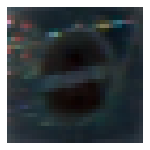

1/1 [==============================] - 0s 35ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(43,)
Class: 2
Label: Speed limit (50km/h)
(1, 32, 32, 3)
[11]


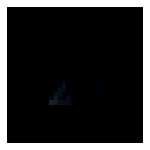

1/1 [==============================] - 0s 31ms/step
(43,)
Class: 11
Label: Right-of-way at the next intersection
(1, 32, 32, 3)
[11]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


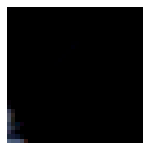

1/1 [==============================] - 0s 35ms/step
(43,)
Class: 35
Label: Ahead only
(1, 32, 32, 3)
[11]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


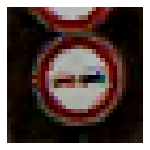

1/1 [==============================] - 0s 31ms/step
(43,)
Class: 9
Label: No passing
(1, 32, 32, 3)
[11]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


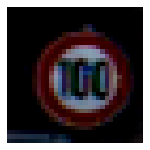

1/1 [==============================] - 0s 50ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(43,)
Class: 7
Label: Speed limit (100km/h)
(1, 32, 32, 3)
[11]


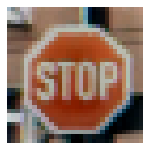

1/1 [==============================] - 0s 45ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(43,)
Class: 14
Label: Stop
(1, 32, 32, 3)
[11]


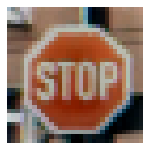

1/1 [==============================] - 0s 30ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(43,)
Class: 14
Label: Stop
(1, 32, 32, 3)
[11]


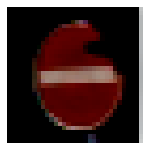

1/1 [==============================] - 0s 30ms/step
(43,)
Class: 17
Label: No entry
(1, 32, 32, 3)
[11]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


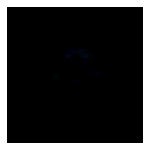

1/1 [==============================] - 0s 31ms/step
(43,)
Class: 7
Label: Speed limit (100km/h)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



(1, 32, 32, 3)
[11]


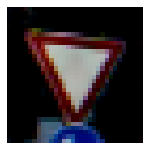

1/1 [==============================] - 0s 28ms/step
(43,)
Class: 13
Label: Yield


In [18]:
from random import randint
images = [randint(0, 100) for p in range(0, 10)]
def label_text(file, images, i):
    x_input = data['x_test'][images[i]:images[i]+1]
    print(x_input.shape)
    y_input = data['y_test'][1:2]
    print(y_input)

    plt.rcParams['figure.figsize'] = (2.5, 2.5)
    plt.imshow(x_input[0, :, :, :])
    plt.axis('off')
    plt.show()

    scores = model.predict(x_input)
    print(scores[0].shape)

    prediction = np.argmax(scores)
    print('Class:', prediction)
    label_list = []
    r = pd.read_csv(file)
    for name in r['SignName']:
        label_list.append((name))
    return label_list, prediction

print(len(images))

for i in range(len(images)):
    labels, prediction= label_text('data/label_names.csv', images, i)
    print('Label:', labels[prediction])

In [20]:
model.save('traffic_sign_classifier.h5')